# Inspecting a Spark DataFrame
### With graphics

## Overview

In this module we inspect our DataFrame more carefully.  In particular, we
inspect columns that represent the following types of variables:
 
- Primary key variable
- Categorical variable
- Continuous numerical variable
- Date and time variable
 
In the process, we introduce various Spark SQL functionality that we cover
more formally in subsequent modules.


## Create a SparkSession

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("inspect").getOrCreate()

## Read the raw ride data from HDFS to a Spark SQL DataFrame

In [5]:
RIDES_PATH = "file:///workdir/spark-3.0.1-bin-hadoop2.7-hive1.2/spark-ml/duocar/raw/rides"
rides = spark.read.csv(RIDES_PATH, header=True, inferSchema=True)

## Inspecting a DataFrame

In [6]:
# Print the schema:
rides.printSchema()

root
 |-- id: integer (nullable = true)
 |-- driver_id: long (nullable = true)
 |-- rider_id: long (nullable = true)
 |-- date_time: string (nullable = true)
 |-- utc_offset: integer (nullable = true)
 |-- service: string (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_lon: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_lon: double (nullable = true)
 |-- distance: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- cancelled: integer (nullable = true)
 |-- star_rating: integer (nullable = true)



Use the *pandas* library to display the DataFrame as a scrollable HTML table:

In [7]:
import pandas as pd
pd.options.display.html.table_schema=True
rides.limit(5).toPandas()

,id,driver_id,rider_id,date_time,utc_offset,service,origin_lat,origin_lon,dest_lat,dest_lon,distance,duration,cancelled,star_rating
0,1,220200000214,220200000084,2017-02-01 00:14,-6,None,46.850956,-96.902849,46.860050,-96.825442,10123,729,0,5
1,2,220200000107,220200000462,2017-02-01 00:36,-6,None,46.900432,-96.765807,46.840588,-96.868087,16043,1299,0,5
2,3,220200000214,220200000489,2017-02-01 02:26,-6,Noir,46.868382,-96.902718,46.815272,-96.862056,9362,736,0,5
3,4,220200000067,220200000057,2017-02-01 03:00,-6,None,46.908567,-96.905391,46.904380,-96.793999,9060,773,0,5
4,5,220200000067,220200000012,2017-02-01 03:49,-6,None,46.895864,-96.805807,46.869030,-96.785232,5076,721,0,5


**Note:** The `limit` method returns a DataFrame with the specified number of
rows; the `toPandas` method returns a pandas DataFrame.

Use the `describe` method to get basic summary statistics on each column:

In [8]:
rides.describe().toPandas()

,summary,id,driver_id,rider_id,date_time,utc_offset,service,origin_lat,origin_lon,dest_lat,dest_lon,distance,duration,cancelled,star_rating
0,count,48775,48775,48775,48775,48775,17389,48775,48775,48775,48775,45841,45841,48775,45841
1,mean,24388.0,2.202000007939952E11,2.2020000080101028E11,None,-5.338308559712968,None,46.865850124940806,-96.81245391579934,46.86475293472024,-96.81545354413292,8904.418948103226,687.0703736829475,0.06015376729882112,4.2536812024170505
2,stddev,14080.274026689489,524.5246758760943,528.7220000512307,None,0.4731389518881924,None,0.05440340564555947,0.11446661790876063,0.04211823662942229,0.09537454957127935,8797.103315891003,361.46343912255486,0.23777394875431898,1.137272514286516
3,min,1,220200000007,220200000001,2017-02-01 00:14,-6,Elite,46.633395,-97.674931,46.633395,-97.674931,304,28,0,0
4,max,48775,220200002259,220200002286,2017-04-22 23:58,-5,Noir,47.237408,-96.178997,47.237408,-96.178997,92204,3536,1,5


**Note:**  The `describe` method returns a DataFrame.


## Inspecting a DataFrame column

### Inspecting a primary key variable

The `id` column represents a primary key variable:

In [9]:
rides.select("id").show(10)

+---+
| id|
+---+
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
| 10|
+---+
only showing top 10 rows



**Note:** `select` is a DataFrame method that returns a DataFrame.

The `id` column should be non-null and unique.  Count the number of missing
(null) values:

In [10]:
rides.filter(rides.id.isNull()).count()

0

**Note:** `filter` is a DataFrame method that returns a DataFrame consisting
of the rows for which its argument is true.  `rides.id` is a Column object
and `isNull` is a Column method.

Count the number of rows:

In [11]:
rides.count()

48775

Count the number of distinct values:

In [12]:
rides.select("id").distinct().count()

48775

Count the number of non-missing and distinct values using Column functions:

In [13]:
from pyspark.sql.functions import count, countDistinct
rides.select(count("*"), count("id"), countDistinct("id")).show()

+--------+---------+------------------+
|count(1)|count(id)|count(DISTINCT id)|
+--------+---------+------------------+
|   48775|    48775|             48775|
+--------+---------+------------------+



We have been using the DataFrame API of Spark SQL.  To use the SQL API to
count the number of non-missing and distinct values, first register the
DataFrame as a *temporary view*:

In [14]:
rides.createOrReplaceTempView("rides_view")

Then use the `sql` method to run a query:

In [15]:
spark.sql("SELECT COUNT(*), COUNT(id), COUNT(DISTINCT id) FROM rides_view").show()

+--------+---------+------------------+
|count(1)|count(id)|count(DISTINCT id)|
+--------+---------+------------------+
|   48775|    48775|             48775|
+--------+---------+------------------+



**Note:** The `sql` method returns a DataFrame.

### Inspecting a categorical variable
The `service` column represents a categorical variable:

In [16]:
rides.select("service").show(10)

+-------+
|service|
+-------+
|   null|
|   null|
|   Noir|
|   null|
|   null|
|   null|
|   null|
|   null|
|   null|
|   null|
+-------+
only showing top 10 rows



**Question:** What do the missing (null) values represent?

Count the number of missing (null) values:

In [17]:
rides.filter(rides.service.isNull()).count()

31386

Count the number of distinct values:

In [18]:
rides.select("service").distinct().count()

4

Print the distinct values:

In [19]:
rides.select("service").distinct().show()

+-------+
|service|
+-------+
|   null|
|  Grand|
|  Elite|
|   Noir|
+-------+



Count the number of rides by service:

In [20]:
rides.groupby("service").count().show()

+-------+-----+
|service|count|
+-------+-----+
|   null|31386|
|  Grand| 6197|
|  Elite| 2109|
|   Noir| 9083|
+-------+-----+



Use the SQL API to count the number of rides by service:

In [21]:
spark.sql("SELECT service, COUNT(*) FROM rides_view GROUP BY service").show()

+-------+--------+
|service|count(1)|
+-------+--------+
|   null|   31386|
|  Grand|    6197|
|  Elite|    2109|
|   Noir|    9083|
+-------+--------+



Use pandas to plot the number of rides by service:

<AxesSubplot:xlabel='service'>

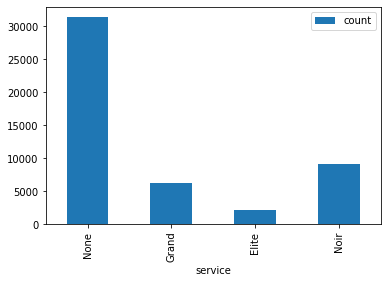

In [22]:
rides.groupby("service").count().toPandas().plot(x="service", y="count", kind="bar")

### Inspecting a numerical variable

The `distance` column represents a numerical variable (stored as an integer):

In [23]:
rides.select("distance").show(10)

+--------+
|distance|
+--------+
|   10123|
|   16043|
|    9362|
|    9060|
|    5076|
|    4683|
|    6230|
|    3824|
|    1366|
|   10510|
+--------+
only showing top 10 rows



Use the `describe` method to compute basic summary statistics:

In [24]:
rides.describe("distance").show()

+-------+-----------------+
|summary|         distance|
+-------+-----------------+
|  count|            45841|
|   mean|8904.418948103226|
| stddev|8797.103315891003|
|    min|              304|
|    max|            92204|
+-------+-----------------+



**Question:** Are there any missing (null) values?

Use the `approxQuantile` method to get customized quantiles:

In [25]:
rides.approxQuantile("distance", \
                     probabilities=[0.0, 0.25, 0.5, 0.75, 1.0], \
                     relativeError=1e-5)

[304.0, 3953.0, 6730.0, 10821.0, 92204.0]

**Note:** The `approxQuantile` method returns a Python list.

**Question:** Why does Spark produce approximate quantiles?

See the documentation for more details:

In [26]:
rides.approxQuantile?

Use pandas to plot a basic histogram:

<AxesSubplot:ylabel='Frequency'>

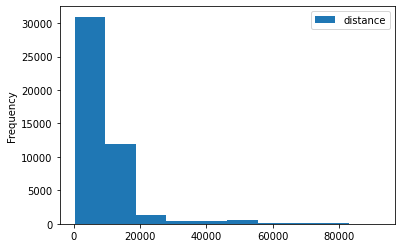

In [27]:
rides.select("distance").toPandas().plot(kind="hist")

**Warning:** `toPandas()` is dangerous in the Spark world.  Why?
 

### Inspecting a date and time variable

The `date_time` column represents a date and time variable:

In [28]:
rides.select("date_time").show(10)

+----------------+
|       date_time|
+----------------+
|2017-02-01 00:14|
|2017-02-01 00:36|
|2017-02-01 02:26|
|2017-02-01 03:00|
|2017-02-01 03:49|
|2017-02-01 03:53|
|2017-02-01 04:13|
|2017-02-01 04:28|
|2017-02-01 04:43|
|2017-02-01 05:01|
+----------------+
only showing top 10 rows



However, Spark read it in as a string:

In [29]:
rides.select("date_time").printSchema()

root
 |-- date_time: string (nullable = true)



Use the `cast` method to convert it to a timestamp:

In [30]:
dates = rides.select("date_time", rides.date_time.cast("timestamp").alias("date_time_fixed"))
dates.show(5)

+----------------+-------------------+
|       date_time|    date_time_fixed|
+----------------+-------------------+
|2017-02-01 00:14|2017-02-01 00:14:00|
|2017-02-01 00:36|2017-02-01 00:36:00|
|2017-02-01 02:26|2017-02-01 02:26:00|
|2017-02-01 03:00|2017-02-01 03:00:00|
|2017-02-01 03:49|2017-02-01 03:49:00|
+----------------+-------------------+
only showing top 5 rows



Note that timestamps are represented by Python `datetime` objects:

In [31]:
dates.head(5)

[Row(date_time='2017-02-01 00:14', date_time_fixed=datetime.datetime(2017, 2, 1, 0, 14)),
 Row(date_time='2017-02-01 00:36', date_time_fixed=datetime.datetime(2017, 2, 1, 0, 36)),
 Row(date_time='2017-02-01 02:26', date_time_fixed=datetime.datetime(2017, 2, 1, 2, 26)),
 Row(date_time='2017-02-01 03:00', date_time_fixed=datetime.datetime(2017, 2, 1, 3, 0)),
 Row(date_time='2017-02-01 03:49', date_time_fixed=datetime.datetime(2017, 2, 1, 3, 49))]

Note that the `describe` method does not generate summary statistics for date
and time variables (unless they are represented as strings):

In [32]:
dates.describe().show(5)

+-------+----------------+
|summary|       date_time|
+-------+----------------+
|  count|           48775|
|   mean|            null|
| stddev|            null|
|    min|2017-02-01 00:14|
|    max|2017-04-22 23:58|
+-------+----------------+



In [33]:
# Execrcices here?

## Cleanup

In [34]:
# Stop the SparkSession:
spark.stop()